In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [6]:
"""Loading LA_Bike Data in variable data and converting index into timestamp"""
data = pd.read_excel("LABikeData.xlsx")
data["Date"] = pd.to_datetime(data["start_time"])  ## Creating new variable Date whose values are taken from start_time
data = data.set_index("Date")

In [7]:
data.shape

(639786, 13)

In [186]:
data["Year"] = data.index.year
data["Month"] = data.index.month
data["Week"] = data.index.week
data["Weekday Name"] = data.index.weekday_name
data["time"] = data.index.time

In [162]:
data.to_csv("LABike_data_with_time_index.csv")

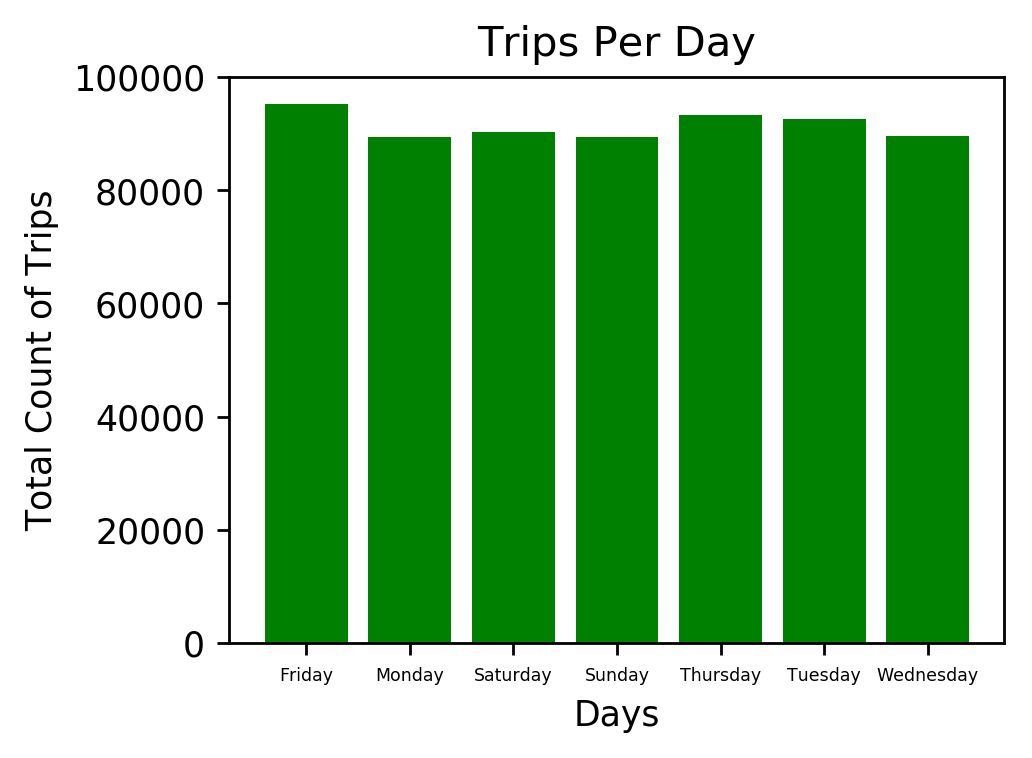

In [11]:
daily_data = data.groupby(by="Weekday Name").count()
pyplot.figure(num=None, figsize=(4, 3), dpi=250, facecolor='w', edgecolor='k')
plt.bar(daily_data.index,daily_data.trip_id, color = "green")
plt.ylabel("Total Count of Trips")
plt.xlabel("Days")
plt.title("Trips Per Day")
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

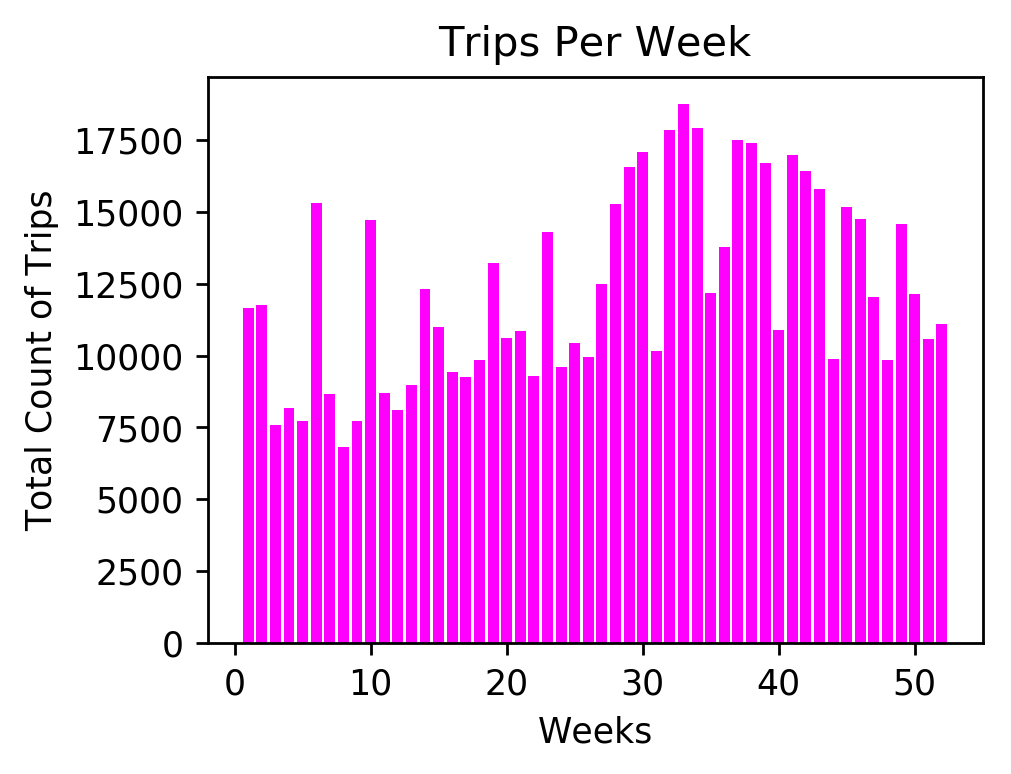

In [12]:
weekly_data = data.groupby(by="Week").count()
pyplot.figure(num=None, figsize=(4, 3), dpi=250, facecolor='w', edgecolor='k')
plt.bar(weekly_data.index,weekly_data.trip_id, color = "magenta")
plt.ylabel("Total Count of Trips")
plt.xlabel("Weeks")
plt.title("Trips Per Week")
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

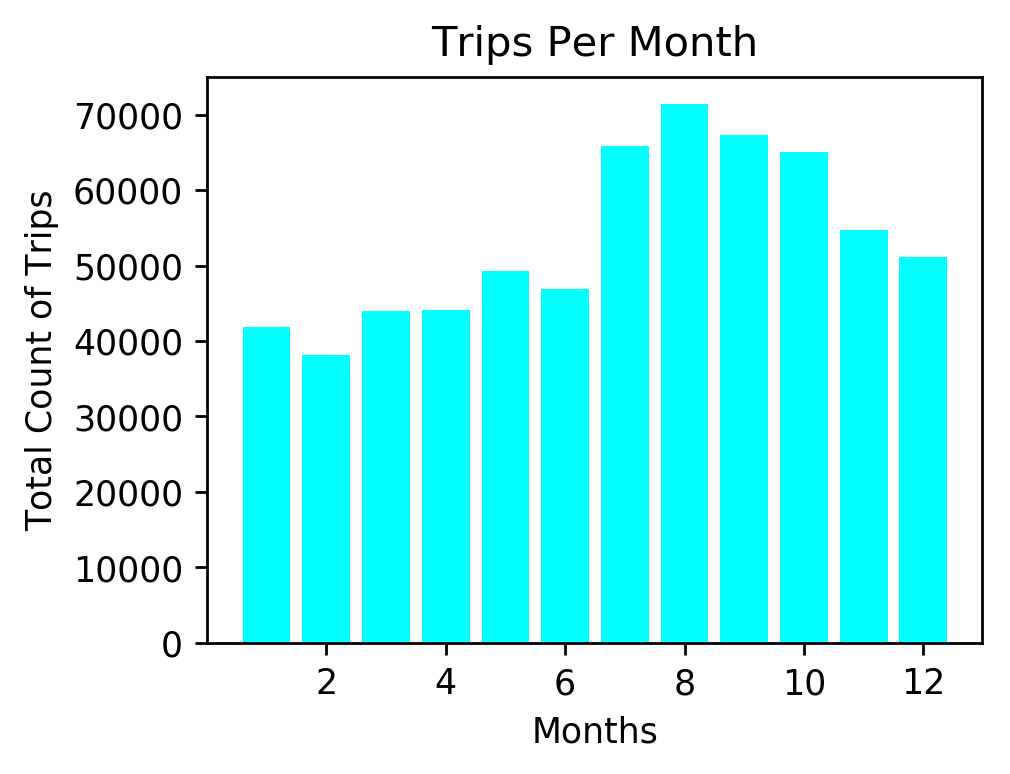

In [14]:
monthly_data = data.groupby(by="Month").count()
pyplot.figure(num=None, figsize=(4, 3), dpi=250, facecolor='w', edgecolor='k')
plt.bar(monthly_data.index,monthly_data.trip_id, color = "cyan")
plt.ylabel("Total Count of Trips")
plt.xlabel("Months")
plt.title("Trips Per Month")
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

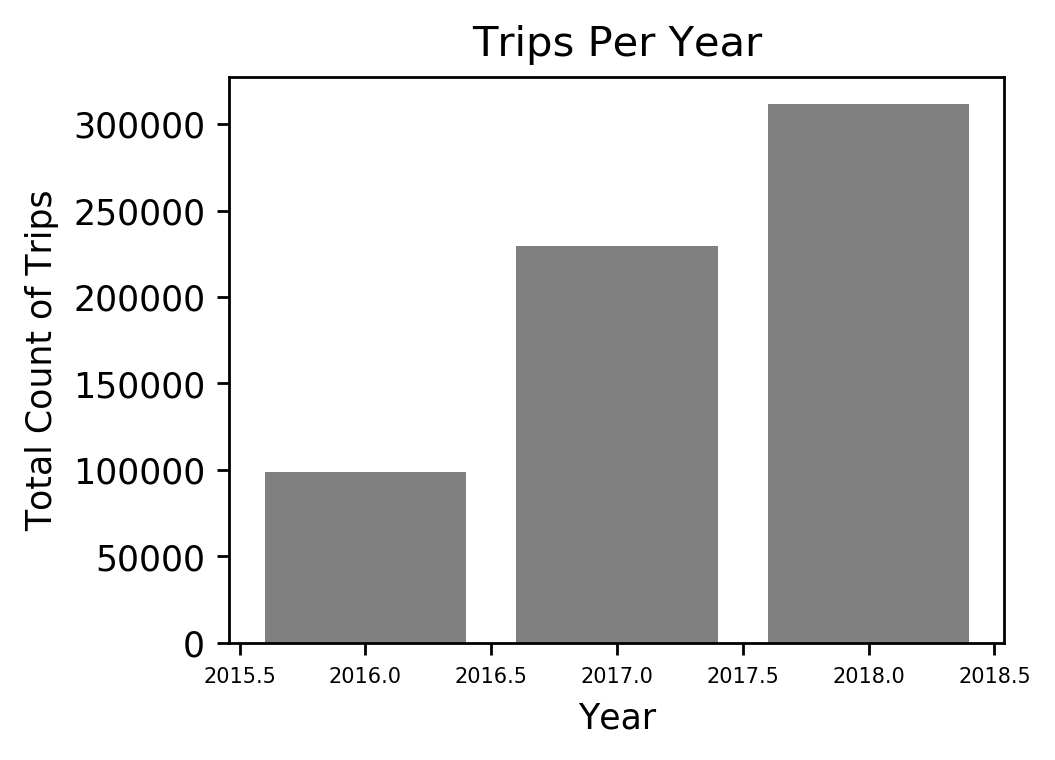

In [17]:
yearly_data = data.groupby(by="Year").count()
pyplot.figure(num=None, figsize=(4, 3), dpi=250, facecolor='w', edgecolor='k')
plt.bar(yearly_data.index, yearly_data.trip_id, color= "grey")
plt.ylabel("Total Count of Trips")
plt.xlabel("Year")
plt.title("Trips Per Year")
plt.rc("xtick", labelsize=6)
plt.rc("ytick", labelsize=10)

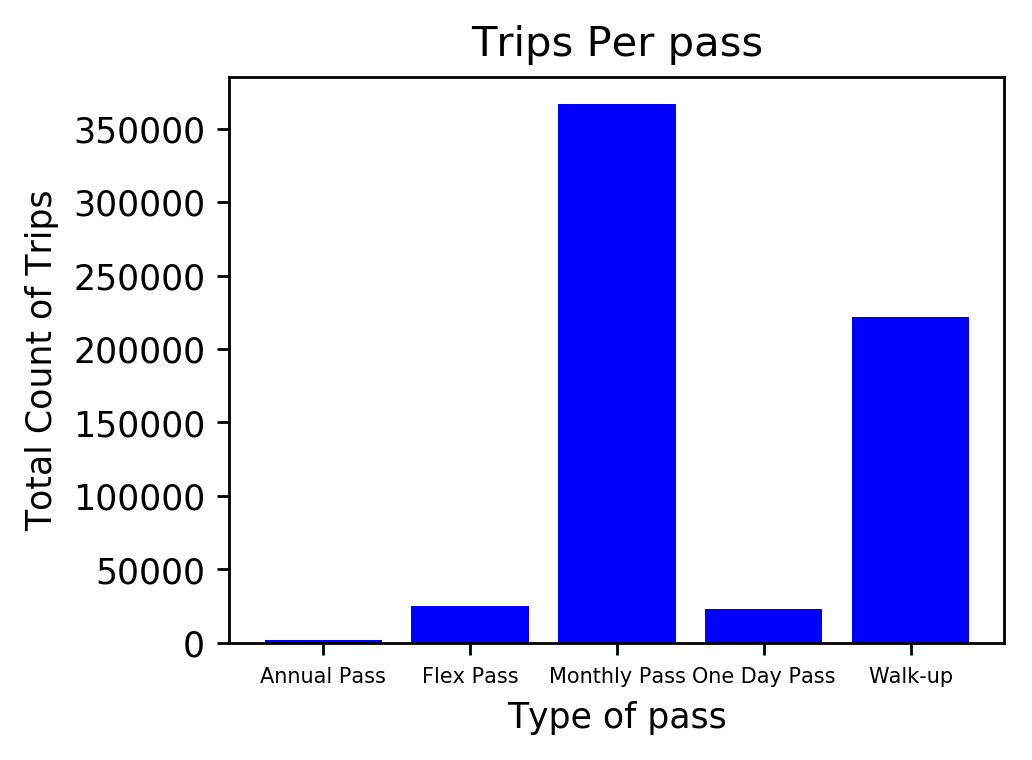

In [18]:
passholder_type_data = data.groupby(by="passholder_type").count()
pyplot.figure(num=None, figsize=(4, 3), dpi=250, facecolor='w', edgecolor='k')
plt.bar(passholder_type_data.index, passholder_type_data.trip_id, color= "blue")
plt.ylabel("Total Count of Trips")
plt.xlabel("Type of pass")
plt.title("Trips Per pass")
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

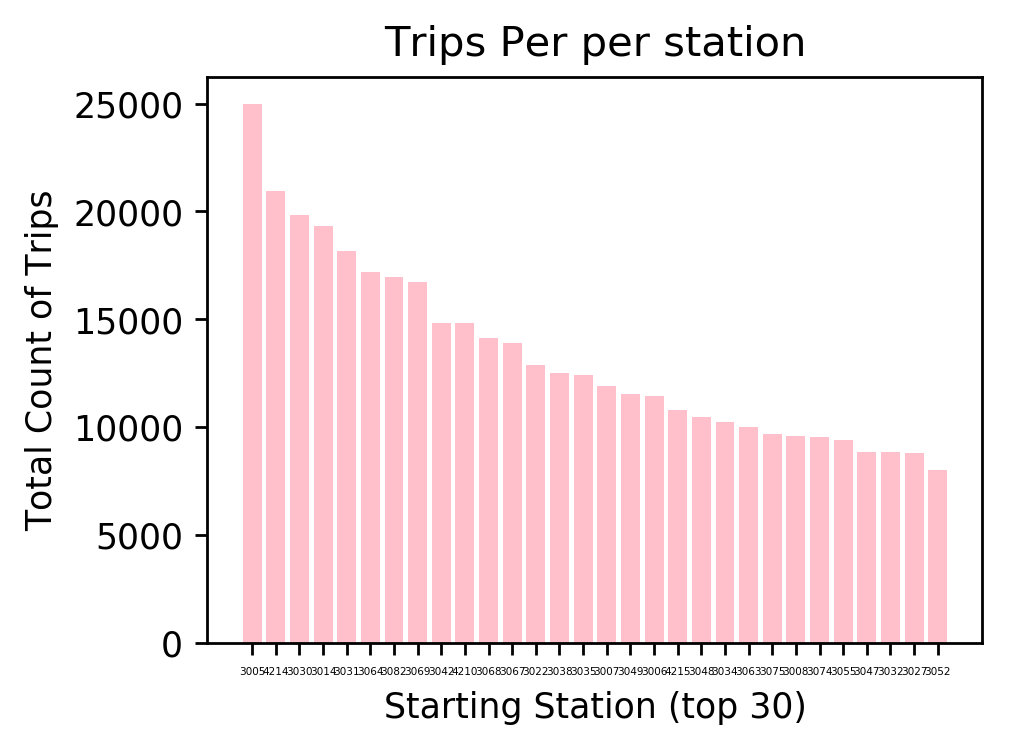

In [24]:
start_station_data = data.groupby(by="start_station").count()
start_station_data.index = [str(ind) for ind in start_station_data.index]
start_station_data = start_station_data.sort_values(by=["trip_id"], ascending= False)
first_30 = start_station_data.iloc[:30]
pyplot.figure(num=None, figsize=(4, 3), dpi=250, facecolor='w', edgecolor='k')
plt.bar(first_30.index, first_30.trip_id, color= "pink")
plt.ylabel("Total Count of Trips")
plt.xlabel("Starting Station (top 30)")
plt.title("Trips Per per station")
plt.rc("xtick", labelsize=2)
plt.rc("ytick", labelsize=10)

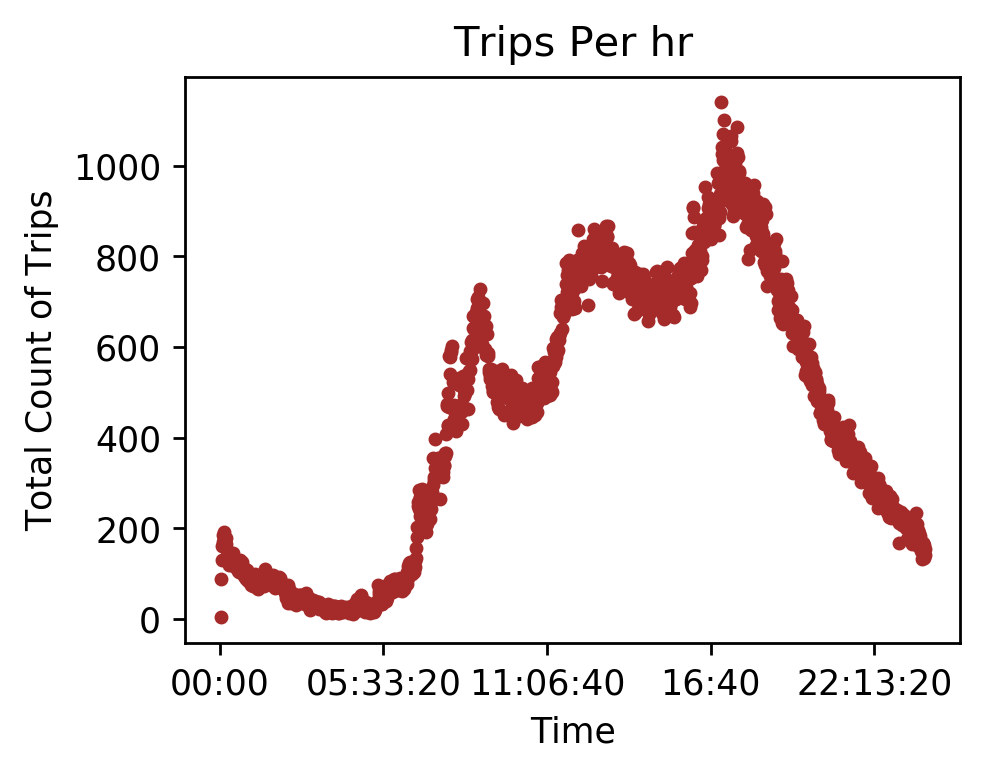

In [26]:
time_data = data.groupby(by="time").count()
pyplot.figure(num=None, figsize=(4, 3), dpi=250, facecolor='w', edgecolor='k')
plt.scatter(time_data.index, time_data.trip_id, color= "brown", marker=".")
plt.ylabel("Total Count of Trips")
plt.xlabel("Time")
plt.title("Trips Per hr")
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

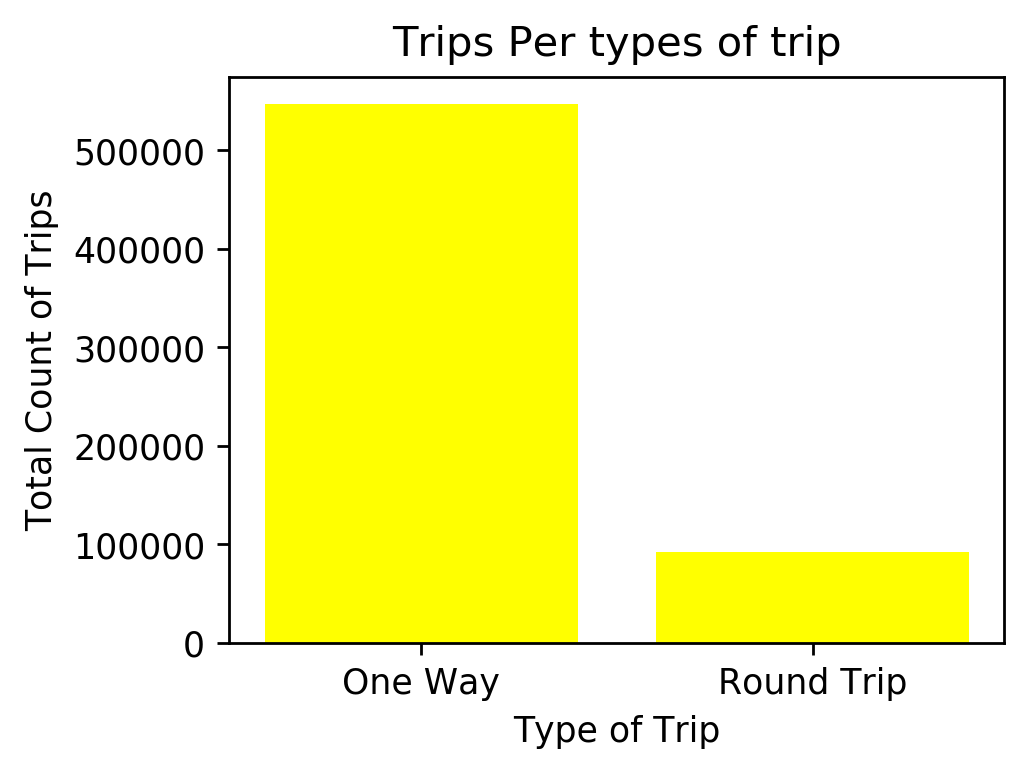

In [27]:
trip_data = data.groupby(by="trip_route_category").count()
pyplot.figure(num=None, figsize=(4, 3), dpi=250, facecolor='w', edgecolor='k')
plt.bar(trip_data.index, trip_data.trip_id,color= "yellow")
plt.ylabel("Total Count of Trips")
plt.xlabel("Type of Trip")
plt.title("Trips Per types of trip")
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [151]:
df = data.dropna()
df["end_station"] = [int(stn) for stn in df.end_station]   ## Converting float values to interger. 

start_stn = list(set(df.start_station))
end_stn = list(set(df.end_station))

"""Length is not same of start station and end station"""
print(len(end_stn) == len(start_stn))

""" length of ens station is 142 and length of start station is 140"""

"""As length is not same of these two list, a search method is used to identify which element 
is missing from the start station, hence the next chunk of code is to find
the station number not in the start station list"""
remove_stn = []
for i in range(len(end_stn)):
    if end_stn[i] not in start_stn:
        remove_stn.append(end_stn[i])
        
for i in range(len(remove_stn)):
    end_stn.remove(remove_stn[i])
    
"""Removing rows with station number 4110 and 4118 as it is discarded from the analysis"""
index_df =[]
for i in range(len(df.end_station)):
    if df.end_station[i] == remove_stn[0] or df.end_station[i] == remove_stn[1]:
        index_df.append(df.index[i])
df = df.drop(index_df)
     

"""Now creating a matrix of 140 x 140 with each station number"""
matrix = np.zeros([140,140])
station = start_stn
strt_end_station = np.stack([df.start_station , df.end_station], axis= 0)

for i in range(len(strt_end_station[0])):
    index1 = station.index(strt_end_station[0][i])
    index2 = station.index(strt_end_station[1][i])
    matrix[index1][index2] +=1
    
Station_to_Stn_trip = pd.DataFrame(matrix, index= station, columns=station)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


False


In [12]:
data_station = data.groupby(by=["start_station", 'Weekday Name']).count()